# Spatial Transformer Networks

元論文: [spatial transformer network](https://arxiv.org/pdf/1506.02025.pdf)

簡単に言うと以下のステップを用いて予測タスクを行います

1. 画像の内部でどこに重要なものが写っているのかを予測するモデルで画像の変換パラメータを予測
2. 1.で予測されたパラメータを用いて入力画像を変換
3. 変換された画像を CNN などに入力してラベルを予測

In [36]:
import torch
from torch import nn, optim
from torch.nn import Sequential
from torch.utils.data import DataLoader

import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

from tqdm import tqdm
import numpy as np
import pandas as pd
from logging import getLogger, StreamHandler

import matplotlib.pyplot as plt
% matplotlib inline

In [38]:
logger = getLogger(__name__)
sh = StreamHandler()
logger.setLevel("INFO")
sh.setLevel("INFO")
logger.addHandler(sh)

In [3]:
device = torch.device("cuda")

In [4]:
data_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1, ), (0.3, ))
])

In [5]:
train_data = datasets.EMNIST(root="../dataset/emnist", split="balanced", train=True, download=True, transform=data_transformer)
test_data = datasets.EMNIST(root="../dataset/emnist", split="balanced", train=False, download=True, transform=data_transformer)

In [6]:
n_batch = 64
train_loader = DataLoader(train_data, batch_size=n_batch, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=n_batch, shuffle=True, num_workers=4)

In [7]:
len(train_loader.dataset)

112800

In [8]:
class SpatialTransformer(nn.Module):
    """
    画像をアフィン変換するモデル
    """
    
    def __init__(self, input_channels=1):
        """
        :param int input_channel: 入力画像のチャネル数.
        """
        super().__init__()
        self.feature = Sequential(
            nn.Conv2d(input_channels, 8, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        self.flatten_dim = 16 * 4 * 4
        
        self.regression = Sequential(
            nn.Linear(self.flatten_dim, 32),
            nn.ReLU(True),
            # 予測するパラメータはアフィン変換のパラメータ (中心, 倍率) * (x, y, chanel)
            nn.Linear(32, 3 * 2)
        )
        
        # 出力値ははじめ 回転 0 拡大率 1 にしておきたいので
        # 重みを 0 バイアスを diag
        output_layer = self.regression[-1]
        output_layer.weight.data.zero_()
        output_layer.bias.data.copy_(
            torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float)
        )
        
    def forward(self, x):
        """
        順伝搬の計算
        """
        
        feature = self.feature(x)
        feature = feature.view(-1, self.flatten_dim)
        theta = self.regression(feature)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, size=x.size())
        x = F.grid_sample(x, grid=grid)
        return x

In [33]:
class CNNModel(nn.Module):
    def __init__(self, input_channels=1, use_spatial_transform=True):
        super().__init__()
        self.use_spatial_transform = use_spatial_transform
        self.spatial = SpatialTransformer(input_channels)
        self.conv1 = nn.Conv2d(input_channels, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 32, kernel_size=5)
        self.flatten_dim = 32 * 4 * 4
        self.fc1 = nn.Linear(self.flatten_dim, 50)
        self.fc2 = nn.Linear(50, 47)
        
    def forward(self, x):
        if self.use_spatial_transform:
            x = self.spatial(x)
        h = F.max_pool2d(self.conv1(x), 2)
        h = F.relu(h)
        h = F.max_pool2d(self.conv2(h), 2)
        h = F.relu(h)
        
        h = h.view(-1, self.flatten_dim)
        h = F.relu(self.fc1(h))
        h = F.dropout(h, training=self.training)
        h = self.fc2(h)
        pred = F.log_softmax(h, dim=1)
        return pred

In [34]:
sp_model = CNNModel(input_channels=1)
sp_model = model.to(device)

In [35]:
normal_model = CNNModel(input_channels=1, use_spatial_transform=False)
normal_model = normal_model.to(device)

In [13]:
def adjust_lr(optimizer, epoch, init_lr=0.01, decay=.5, steps=2):
    lr = init_lr * (decay ** (epoch // steps))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [41]:
def train(model, epochs=20):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=.8, weight_decay=1e-7, nesterov=True)
    losses = []
    for epoch in range(epochs):
        _loss_i = []
        for batch_idx, (x, t) in tqdm(enumerate(train_loader), total=int(len(train_loader.dataset)/n_batch)):
            x, t = x.to(device), t.to(device)

            optimizer.zero_grad()
            pred = model(x)
            loss = F.nll_loss(pred, t)
            loss.backward()
            optimizer.step()
            _loss_i.append(loss.item())

        adjust_lr(optimizer, epoch=epoch)
        train_loss = np.mean(_loss_i)
        logger.info("train loss\t{}".format(train_loss))
        losses.append(train_loss)
    return losses

In [42]:
df = pd.DataFrame()
for m, name in zip([sp_model, normal_model], ("spatial", "normal")):
    df[name] = train(m)

1763it [00:04, 364.13it/s]                          
train loss	0.5755740460251383
INFO:__main__:train loss	0.5755740460251383
1763it [00:04, 361.80it/s]                          
train loss	0.5774350414053662
INFO:__main__:train loss	0.5774350414053662
1763it [00:04, 364.57it/s]                          
train loss	0.5761443933369554
INFO:__main__:train loss	0.5761443933369554
1763it [00:04, 358.10it/s]                          
train loss	0.5095161854020588
INFO:__main__:train loss	0.5095161854020588
1763it [00:04, 365.24it/s]                          
train loss	0.49201775838790535
INFO:__main__:train loss	0.49201775838790535
1763it [00:05, 350.49it/s]                          
train loss	0.4617097090572643
INFO:__main__:train loss	0.4617097090572643
1763it [00:05, 349.59it/s]                          
train loss	0.45745394545830725
INFO:__main__:train loss	0.45745394545830725
1763it [00:04, 354.19it/s]                          
train loss	0.43723624888902624
INFO:__main__:train los

In [43]:
df

,spatial,normal
0,0.575574,1.608386
1,0.577435,0.913390
2,0.576144,0.784983
3,0.509516,0.687281
4,0.492018,0.658398
5,0.461710,0.625195
6,0.457454,0.614445
7,0.437236,0.591933
8,0.431502,0.583941
9,0.419963,0.578083


In [44]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

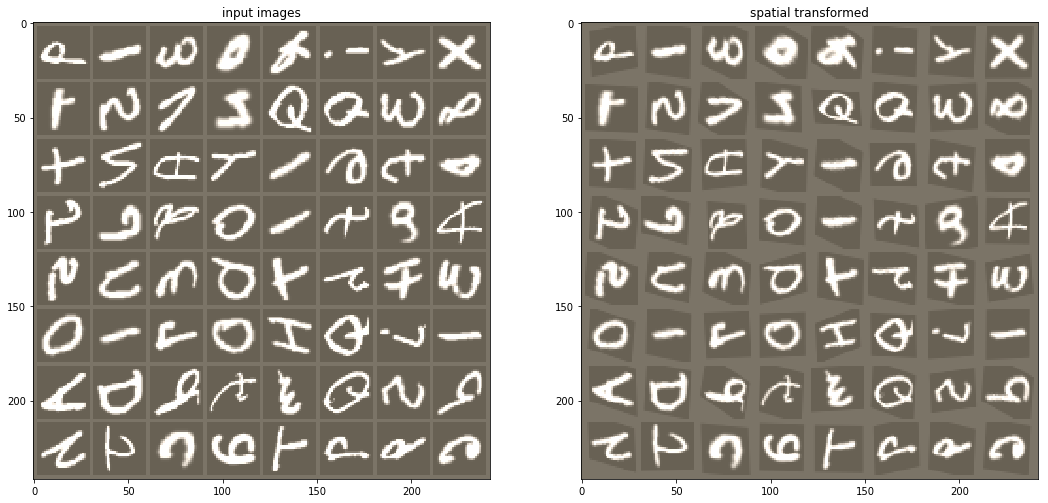

In [50]:
with torch.no_grad():
    x = next(iter(test_loader))[0].to(device)
    
    tensor = x.cpu()
    transformed_tensor = model.spatial(x).cpu()
    
    input_grids = convert_image_np(torchvision.utils.make_grid(tensor))
    transformed_grids = convert_image_np(torchvision.utils.make_grid(transformed_tensor))
    
    fig = plt.figure(figsize=(18, 9))
    axes = fig.subplots(1, 2)
    
    axes[0].imshow(input_grids)
    axes[0].set_title("input images")
    axes[1].imshow(transformed_grids)
    axes[1].set_title("spatial transformed")

In [63]:
input_grids.shape

(242, 242, 3)

In [76]:
test_data.test_labels[:10]

tensor([ 41,  39,   9,  26,  44,  33,  14,  11,   3,  12])

In [75]:
test_data.test_data[:10].shape

torch.Size([10, 28, 28])

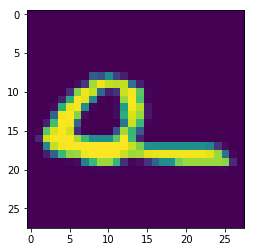

In [66]:
plt.imshow(x[0].cpu().numpy().transpose((1, 2, 0)).reshape(28, 28))

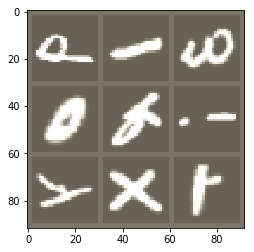

In [71]:
plt.imshow(convert_image_np(torchvision.utils.make_grid(x[:9].cpu(), nrow=3)))

TypeError: Invalid dimensions for image data

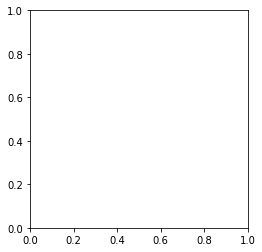

In [55]:
plt.imshow()

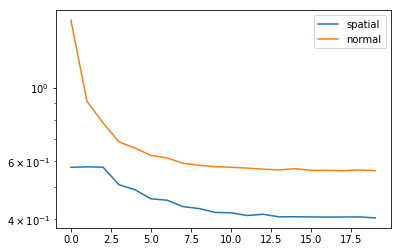

In [48]:
axis = df.plot()
axis.set_yscale("log")